# Семинар 10: бутсрэп

## 1. О котах и печеньках
Сегодня мы посмотрим на данные одной мобильной игрушки под названием "Cookie Cats", разработанной компанией <a href="http://tactile.dk">Tactile Entertainment</a>. Это стандартный match-three пазл, где игрокам нужно соединять элементы одинаковых цветов, чтобы очистить поле и выиграть на уровне. И еще там есть поющие коты. Это важно. 

<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>

По мере того, как игроки проходят уровни, они встречают ворота-блокеры, которые вынуждают их либо ждать длительное время, либо совершить внутриигровую покупку, чтобы продолжить играть. Помимо того, что эти ворота приносят разработчикам деньги от покупок, они еще и вынуждают игроков делать перерыв, в надежде на то, что те вернутся с новыми силами и снова начнут получать удовольствие от котиков. 

<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>

Но возникает вопрос - когда и где ставить эти ворота? Изначально первые ворота стояли на 30-м уровне игры, однако в этом ноутбуке мы будем анализировать АБ-тест, в котором разработчики передвинули ворота на 40-й уровень. В частности мы будем смотреть влияние этого изменения на такой важный показатель как "retention" или удержание игроков, который расчитывается как отношение уникальных игроков, зашедших в игру на 1-й, 2-й, ... N-й день после установки ко всем игрокам, установившим приложение в этот день. 

In [1]:
# Подгружаем pandas
import pandas as pd
# Считываем данные
df = pd.read_csv('cookie_cats.csv')

# Посмотрим на первые строки датасета
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [2]:
df.shape

(90189, 5)

## Данные для АБ-теста

Итак, собраны данные по 90,189 игроках, которые установили игру во время запущенного теста. У нас есть следующие переменные:

<ul>
<li><code>userid</code> - уникальный номер, идентифицирующий каждого игрока.</li>
<li><code>version</code> - был ли пользователь отнесен к контрольной группе (<code>gate_30</code> - ворота на 30-м уровне) или к тестовой (<code>gate_40</code> - ворота на 40-м уровне).</li>
<li><code>sum_gamerounds</code> - число сессий, сыгранных игроком в течение первых 14 дней после установки игры.</li>
<li><code>retention_1</code> - вернулся ли игрок после <strong>первого</strong> дня с момента установки?</li>
<li><code>retention_7</code> - вернулся ли игрок после <strong>седьмого</strong> дня с момента установки?</li>
</ul>

Когда игрок устанавливает игру, он/она случайным образом относятся либо к группе gate_30, либо gate_40. На всякий случай, давайте проверим, действительно ли их примерно поровну в каждой из группу.

In [3]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


## 3. Распределение числа игровых сессий
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/mr_waffles_smiling.png" style="width:200px; float:left"> </p>
<p>Похоже, что игроков действительно примерно поровну в каждой из групп, отлично!</p>
<p>Фокус нашего анализа будет сосредоточен на удержании игроков (retention), но ради интереса давайте построим распределение числа игровых сессий, сыгранных игроками в течение их первой недели жизни в игре.</p>

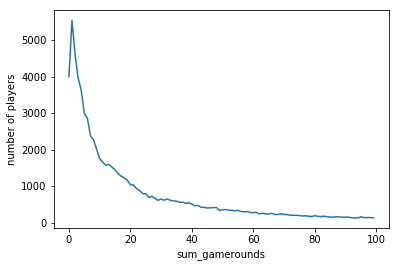

In [4]:
# Эта команда позволяет прорисовывать грфики прямо в ноутбуке
%matplotlib inline

# Считаем число игроков, оставшееся в игре для каждого раунда
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Распределение людей, сыгравших от 0 до 100 раундов
ax = plot_df.head(100).plot()
ax.set_xlabel("sum_gamerounds")
ax.set_ylabel("number of players");

## 4. Общее удержание первого дня (1-day retention)
<p>На графике вверху мы видим, что некоторые игроки установили игру, но даже ни разу не поиграли (0 сессий), многие игроки закончили лишь пару сессий за первую неделю, а некоторые действительно подсели и сыграли более 80 раз!</p>
<p>Конечно, мы хотим, чтобы игроки были заинтересованы в игрушке и возвращались в неё снова и снова. Обычная метрика, использующаяся в гейм-индустрии, чтобы измерить, насколько игрушка веселая и захватывающая, - это <em>удержание первого дня</em> (1-day retention): Процент игроков, которые вренулись и снова стали играть спустя 1 день после установки. Чем выше удержание первого дня, тем проще и дальше удерживать пользователей и строить себе большую базу фанатов.</p>
<p>В качестве первого шага, давайте посмотрим, как в целом выглядит 1-day retention.</p>

In [5]:
df.retention_1.mean()

0.4452095044850259

## 5. 1-day retention по АБ-группам 
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/belle_cookie.png" style="width:200px; float:right"> </p>
<p>Итак, немногим меьше половины всех игроков возвращяются к нам спустя один день после установки. Теперь, когда у нас есть это базовое значение (benchmark), давайте посмотрим, как отличается 1-day retention внутри наших тестовых групп.</p>

In [6]:
df.groupby('version').retention_1.mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## 6. Должны ли мы быть уверены в разнице? 
<p>Похоже, что у нас есть небольшое ухудшение в удержании первого дня, если мы двигаем ворота к сороковому уровню (44.2%) в сравнеии с контрольной группой, где ворота остались на 30-м уровне (44.8%). Разница, конечно, невелика, но даже маленькие изменений в удержании могут иметь значительные последствия. Однако сейчас мы уверены, что различие есть в наблюдаемых данных, а будет ли вариант с воротами на сороковом уровне хуже в будущем?</p>
<p>Есть несколько способов оценки нашей уверенности в наблюдаемых цифрах. Здесь мы попробуем метод под названием бутстрап (bootstrap). Мы будем последовательно ресэмплить с возвращением наш датасет (то есть выбирать случайную подвыборку из всего множества наблюдений) и для каждой выборки считать удержание первого дня. Дисперсия нашего 1-day retention при таком способе вычисления даст нам указание на то, насколько мы должны быть неуверены в оценках нашего удержания.</p>

In [7]:
iterations = 500

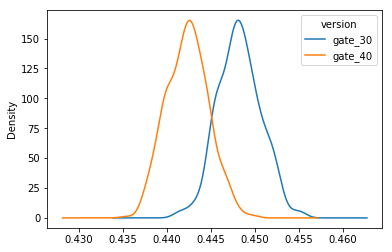

In [8]:
# Создаём лист с бутстрапированными средними для каждой АБ-группы
boot_1d = []
for i in range(iterations):
    boot_mean = df.sample(frac=1, replace=True).groupby('version').retention_1.mean()
    boot_1d.append(boot_mean)
    
# Превращаем лист в датафрейм
boot_1d = pd.DataFrame(boot_1d)
    
# Распределение средних значений в разных группах
boot_1d.plot.kde();

## 7. Смотрим на разницу поближе
<p>Эти два распределения представляют собой оценку распределений 1-day retention для наших двух АБ-групп. Даже просто визуально понятно, что какое-то доказательство различия двух групп у нас есть. Посмотрим теперь подробнее на разницу в ретеншене у двух групп.</p>
<p>(<em>Чтобы посчиталось быстрее число  итераций мы выбрали достаточно небольшим - всего 500 раз считаем средние по выборкам. В боевых условиях число было бы больше, например, 10 тысяч итераций. </em>)</p>

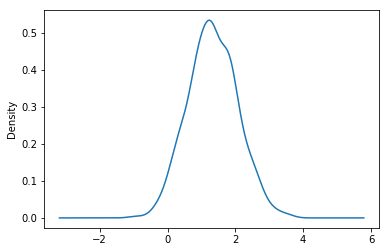

In [10]:
# Добавим колонку с процентной разницей между двумя группами
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40) / boot_1d.gate_40 * 100

# Строим рпспределение разницы между группами
ax = boot_1d['diff'].plot.kde()

## 8. Вероятность разницы
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/ziggy_smiling.png" style="width:200px; float:left"> </p>
<p>Из этого графика мы видим, что наиболее вероятная разница составляет примерно 1%-2%, а большая часть распределения находится справа от нуля, то есть вариант с воротами на 30 уровне пока выигрывает. Но какова вероятность того, что эта разница больше 0%? Посчитаем и её тоже.</p>

In [11]:
# Найдём вероятность того, что 1-day retention больше, когда ворот на 30 уровне
prob = (boot_1d['diff'] > 0).mean()

# Красиво выведем эту вероятность на экран
print('{:.1%}'.format(prob))

97.6%


## 9. 7-day retention по АБ-группам
<p>Бутстрап-анализ свидетельствует о высокой вероятности того, что удержание первого дня лучше в группе с воротами на 30-м уровне, чем на 40-м. Однако, так как игроки упели пожить в игре всего один день, вполне возможно, что их большинство еще даже не дошли даже до 30-го уровня. А значит, многие игроки не будут затронуты нашим изменением и сильного эффекта мы не увидим.</p>
<p>Однако спустя неделю после установки, уже больше игроков пройдут 40 уровней, поэтому имеет смысл посмотреть на удержание седьмого дня. Т.е., какой процент людей, установивших игру, снова показался в игре через 7 дней.</p>
<p>Начнем с рассчета 7-day retention для двух АБ-групп.</p>

In [12]:
# Найдём 7-day retention для обеих групп
df.groupby('version').retention_7.mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

## 10. Снова бутстрапим разницу 
<p>Как и с 1-day retention, мы видим, что 7-day retention немного ниже (18.2%), когда ворота находятся на 40-м уровне, чем на 30-м (19.0%). Эта разница также выше, чем для удержания первого дня, скорее всего из-за того, что игроки имели больше времени на то, чтобы столкнуться с первыми воротами. Мы также видим, что удержание 7-го дня в целом ниже, чем удержание 1-го - спустя неделю намного меньше людей всё ещё заходит в игру.<p>Но как и раньше, давайте применим бутстрап анализ и выясним, насколько уверены мы должны быть в разнице между двумя АБ-группами.</p>

100.0%


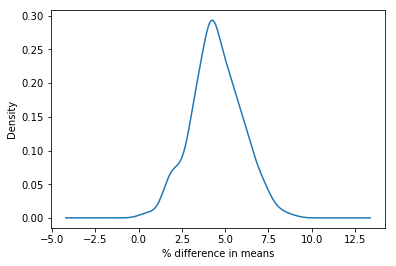

In [12]:
# Создаём лист с бутстрапированными средними для каждой АБ-группы
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version').retention_7.mean()
    boot_7d.append(boot_mean)
    
# Превращаем лист в датафрейм
boot_7d = pd.DataFrame(boot_7d)

# Добавим колонку с процентной разницей между двумя группами
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40) / boot_7d.gate_40 * 100

# Строим рпспределение разницы между группами
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")

# Найдём вероятность того, что 7-day retention больше, когда ворот на 30 уровне
prob = (boot_7d['diff'] > 0).mean()

# Красиво выведем эту вероятность на экран
print('{:.1%}'.format(prob))

## 11.  Выводы
<p>Итак, результаты бутстрапа говорят нам о том, что есть значительное доказательство превышения 7-day retentino в группе с воротами на 30-м уровне над группой с воротами на 40-м. Значит, если мы хотим держать ретеншн на высоком уровне и иметь большее число игроков, нам <strong>не нужно</strong> сдвигать ворота с 30-го на 40-й уровень.
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_yellow.png" style="width:100px; float:center"> </p>
<p>Так почему же ретеншн выше, когда ворота расположены раньше? Логично было бы ожидать обратной ситуации - чем позже ставится препятствие, тем дольше игроки будут взаимодействовать с игрой. Однако это не то, что мы видим в данных. Теория гедонистической адаптации может помочь с объяснением. Если вкратце, гедонистическая адаптация - это тенденция получать всё меньше и меньше удовольствия от деятельности, если она продолжается длительное время. Заставляя игроков сделать паузу, когда они достигают 30-го уровня, мы продлеваем им удовольствие от игры, в результате чего они хотят в неё возвращаться. И напротив, сдвигая ворота к 40-му уровню мы даем игрокам возможность наиграться и просто заскучать.</p>

## 12. В целом про АБ-тесты

Этот параграф писался на основе [вот этой виньетки.](https://yadi.sk/i/FlQe3QHt3WiYyp)

Во всех сферах бизнеса постоянно требуется улучшать его ключевые показатели. Идеи улучшения могут быть совершенно разными. Обычно их очень много. Хочется проверить какие из них будут работать, а какие нет. Тестировать идеи нужно на реальных пользователях. Выделяется группа пользователей, которой показывается некоторое новшество. Когда наберётся достаточно информации, проверяется гипотеза об улучшении ключевой метрики. Схема такой проверки называется A/Б-тестом. 

### Что за улучшение и метрики

Итак, мы придумали идею, которая должна улучшить мир. Чтобы сделать вывод реально ли улучшает наша идея мир, мы должны выбрать какой-то показатель и посмотреть вырастет он или упадёт. Такие показатели называются метриками. Чаще всего при проведении А/Б-теста мы пытаемся понять улучшилось ли состояние бизнеса и поэтому используем метрики, связанные с деньгами. 

Например, увеличились ли продажи, когда мы изменили алгоритм рекомендации товаров. Стали ли люди донатить больше денег, когда мы усложнили прохождение уровня в игре. Выросли ли продажи, когда мы провели маркетинговую компанию и тп. 

Метрики, связанные с деньгами бывают очень грубыми. Они могут слабо реагировать на небольшие изменения или после внесения изменений может потребоваться очень много времени, чтобы измерить их. Из-за этого часто используют промежуточные метрики, который, с одной стороны достаточно чувствительны к изменениям, а с другой, хорошо согласуются с бизнес-показателями, которые в реальности требуется измерить. Например, при внесении изменений на сайт с арендой квартир в качестве такой метрики можно взять "среднее количество визитов на сайт в день" или "среднее число уникальных пользователей" или "количество репостов сайта в социальных сетях".

### Где используются А/Б тесты 

* Любые сайты, независимо от их профиля, используют механизм A/Б-тестирования для принятия решения о внесении каких-то изменений. Аналогично тестируются любые изменения дизайна или функциональности в приложениях или играх. 
* Работоспособность лекарств. Тех, кто согласен принять участие в тесте, делят на две части. Одной дают плацебо, другой реальное лекарство. После смотрят какая доля людей в обеих группах поправилась и делают выводы об эффективности.
* Перед тем как автоматизировать какой-то процесс с помощью алгоритма машинного обучения, всегда проверяется с помощью А/Б-теста будет ли он работать в реальности лучше, чем человек. 
* А/Б-тестирование встречается и в довольно неожиданных местах. При правительствах США и Великобритани есть небольшие группы, которые совместно с психологами-бихевиористами выдвигают гипотезы о том, как люди взаимодействуют с государством, и на основании таких гипотез проводятся эксперименты: например, небольшие изменения в дизайне налоговой формы, или изменения в способе записи на донорство или трансплантацию органов. Такие вещи, которые легко и очень дешево можно поменять, оказывается, приводят к тому, что государство может сэкономить миллионы.


### Кекс про кока-колу

Компания, выпускающая колу решила протестировать как повлияет на продажи увеличение количества сахара в напитке. Для этого была собрана фокус-группа, которой предложили на выбор два напитка: со стандартным содержанием сахара и увеличенным. Людям нужно было попробовать оба и выбрать тот, который им больше понравился. В результате этого исследования выяснилось, что большее количество людей предпочитает Кока-Колу с увеличенным количеством сахара. Было решено увеличить количество сахара в напитке для более широкой аудитории. Неожиданно продажи упали. __Вопрос:__ что пошло не так? 

__Ответ:__ Эксперты стали разбираться почему так произошло, ведь в рамках фокус-группы было показано, что больше сахара — это вкуснее. Выяснилось, что это исследование проходило не в тех самых условиях, в которых люди обычно пьют Кока-Колу. Если речь идёт всего лишь об одном стакане, то, действительно, людям нравится большее количество сахара. Однако если напиток употребляется постоянно в больших количествах, то больше сахара — хуже. Кажется, что это логично: сложно выпить большое количество очень сладкого напитка. Поэтому, когда проводятся исследования на фокус-группах, нужно следить за тем, чтобы условия были максимально приближены к настоящим.

__Мораль:__ любые исследования, которые проводятся в реальности стоят денег и могут привести к потерям. Тестирование идей должно происходить в максимально приближённых к реальности условиях.


### Подводные камни

В целом, процесс A/Б-тестирования распадается на две большие части. Первая часть — это планирование эксперимента: как именно будет выглядеть A/Б-тест, как пользователей будут делить на группы, сколько будет длиться тест и многие другие вопросы, связанные с этим. Вторая часть — это непосредственно проверка гипотез, принятие решения о том, положительно или отрицательно влияют изменения на бизнес в целом. На этапе дизайна возникает огромное количество проблем. 

Мы уже обсудили первый подводный камень: любые изменения должны тестироваться в максимально приближенных к реальности условиях. Иначе можно потерпеть фиаско аналогичное Кока-Коле. 

Есть и другие проблемы. Например, всегда хочется как можно меньше времени тратить на эксперименты и проверить много идей сразу. В такой ситуации будет сложно понять какое именно изменение привело к улучшению. Нужно следить, чтобы один и тот же пользователь не попал сразу в несколько экспериментальных групп. 

Более того, может оказаться, что изменения взаимоуничтожают друг-друга. Одно улучшает метрики, второе всё портит. Если проводится много экспериментов сразу, нужно следить за тем, чтобы они не противоречили друг-другу. Например, известна история о том, как Google тестировал 41 оттенок синего в цвете ссылок в поисковой выдаче. Если допустить, что одновременно еще проводился бы эксперимент о том, как выбрать цвет страницы или цвет, на фоне которого показываются эти ссылки, очевидно, что они не должны быть тех же самых цветов, что и текст ссылок, иначе пользователь просто не сможет ничего прочитать. То есть пример подбора одновременно цвета текста и цвета фона, на котором он показывается, — это пример экспериментов, которые друг с другом не сочетаются.

Для проведения эксперимента требуется небольшая группа пользователей, которой будут показаны изменения. Для того, чтобы результаты, полученные на этой группе, можно было обобщить на всю выборку, она должна быть репрезентативной. Мы уже обсуждали до этого чем череваты проблемы с выборками в плане оценок параметров. Те же проблемы всплывают и тут. С одной стороны экспериментальная группа должна быть рандомизирована. С другой стороны в ней должна быть сохранена стратификация. Так, если известно, что 2/3 пользователей продукта - женщины, то в экспериментальной группе должно быть 2/3 женщин. При дизайне эксперимента между двумя этими вещами должен быть сохранён баланс. При этом не стоит забывать про закон больших чисел. Если в выборке довольно много людей, то, скорее всего, она охватит все страты в нужных пропрорциях. 

Эксперимент может ставиться на одних и тех же пользователях. Может оказаться важным как один и тот же пользователь реагирует на товар без изменений и с изменениями. Как вы помните, такие выборки называются связными. Возможно, что важен порядок предъевляемых изменений. Для того, чтобы понять влияние порядка изменений, можно попробовать использовать дизайн крест-накрест: половине пользователей показать сначала новый вариант, потом - старый, а другой половине - наоборот. 

Можно увидеть изменения там, где их нет. Например, если произошла выкатка на сайт новой кнопки, пользователи могут начать тыкать на неё из-за того, что они удивились новому изменению и хотят проверить что произойдёт. Мы при этом можем обрадоваться тому, что количество кликов увеличилось и решить, что это принесёт нам денег. Такую штуку можно детектировать с помощью обратного эксперимента. Пусть мы выкатили новую версию кнопки. Она показала себя лучше. Давайте расширим её до более большого числа пользователей, но при этом какой-то узкой группе людей продолжим показывать старую версию. Когда ажиотаж из-за любопытства стихнет, мы сможем удостовериться, что число кликов выросло из-за дизайна, проведя на длинном горизонте повторный А/Б-тест. 

Как мы с вами только что убедились, при проверке гипотез можно встреться с подводными камнями вообще везде. Иногда для того, чтобы определить насколько хорошим получился дизайн эксперимента, используют А/А-тест. Технология такого тестированя работает следующим образом: пользователей делят на две группы в соответствии с дизайном и показывают обеим группам старый вариант. Далее проверяют гипотезу о том, что метрики в группах совпадают. Если гипотеза не отвергается, всё круто. Если видны значимые изменения в метриках, у нашего дизайна есть проблемы. 


### Размер выборки 

Итак, дизайн эксперимента разработан, метрики выбраны. Вся экспериментальная структура устойчива и готова к пуску эксеримента. Осталось только решить сколько человек брать в выборку и как долго тест должен длиться. 

Задача определения объёма выборки тесто связана с тем, какой именно статистический инструмент будет использоваться для тестирования. Для каждого критерия подбор объёма осуществляется своим способом.

Обычно, нужно понять какой минимальный размер эффекта мы хотим детектировать. Далее мы должны выбрать уровень значимости и размер ошибки второго рода. Далее, если взять статистический критерий и выразить из него величину $n$, можно понять при каких объёмах выборки этот размер будет улавливаться как значимый. Для различных критериев существуют калькуляторы мощности, в которые можно внести зафиксированные величины и получить на выход неизвестные. 